# World Bank Publication and Research Cover Page Snapshot

In [1]:
%load_ext autotime

In [2]:
%%capture

# get_corpus_path
# get_txt_orig_path

%run ../path_manager.ipynb

time: 90.8 ms


In [3]:
import requests
import json
import os
import time
import glob
import pandas as pd
import re
from joblib import Parallel, delayed
import pdf2image
import PIL

time: 316 ms


In [4]:
class DocumentCover:
    def __init__(self, doc_id, pdf_url, cover_dir, fixed_width=200, fixed_height=None):
        self.doc_id = doc_id
        self.pdf_url = pdf_url
        self.cover_dir = cover_dir
        self.fixed_width = fixed_width
        self.fixed_height = fixed_height
        
        self.fname = os.path.join(self.cover_dir, f'{self.doc_id}.png')

        self.orig_cover = None
        self.cover = None
        self.resized = None
        
    def get_content(self):
        self.resized = False
        res = requests.get(self.pdf_url)
        
        try:
            pages = pdf2image.convert_from_bytes(res.content, size=(self.fixed_width, self.fixed_height), single_file=True)
            self.resized = True
        except:
            pages = pdf2image.convert_from_bytes(res.content)
            
        self.orig_cover = pages[0]

    def standardize_size(self):
        # Not useful if `size` is set in pdf2image.convert_from_bytes
        c = self.orig_cover
        
        if c is None:
            self.get_content()
            c = self.orig_cover
            assert(c)

        if not self.resized:
            width = self.fixed_width
            w0, h0 = c.size
            c = c.resize((width, int(h0 * width / w0)), resample=PIL.Image.BICUBIC)
            
        self.cover = c
        
    def save(self):
        if not os.path.isfile(self.fname):        
            cover = self.cover

            if cover is None:
                self.standardize_size()
                cover = self.cover

            cover.save(self.fname)
        
        return self.doc_id
    
    def cleanup(self):
        del(self.orig_cover)
        del(self.cover)
        
        self.orig_cover = None
        self.cover = None

time: 2.94 ms


In [5]:
COVER_DIR = os.path.join(get_corpus_path('WB'), 'cover')
if not os.path.isdir(COVER_DIR):
    os.makedirs(COVER_DIR)

time: 588 µs


In [6]:
COVER_DIR

'/home/wb536061/wbes2474/NLP/CORPUS/WB/cover'

time: 5.54 ms


In [7]:
# !ls -l /R/NLP/CORPUS/WB/cover | wc -l

time: 207 µs


In [8]:
# df = pd.read_csv('../../Subtopic Prediction/data/wb_metadata.csv')
df = pd.read_csv(os.path.join(get_corpus_path('WB'), 'wb_metadata.csv'))
pr = df[df.major_doc_type == 'Publications & Research'][['id', 'major_doc_type', 'url_pdf']]

pr.dropna(subset=['url_pdf'], inplace=True)

time: 2.65 s


In [9]:
pr.head()

,id,major_doc_type,url_pdf
36,wb_19774480,Publications & Research,http://documents.worldbank.org/curated/en/3919...
42,wb_19623158,Publications & Research,http://documents.worldbank.org/curated/en/9647...
62,wb_31405767,Publications & Research,http://documents.worldbank.org/curated/en/5452...
63,wb_19583798,Publications & Research,http://documents.worldbank.org/curated/en/1980...
64,wb_19550113,Publications & Research,http://documents.worldbank.org/curated/en/2009...


time: 7.21 ms


In [10]:
pr.shape

(53497, 3)

time: 1.45 ms


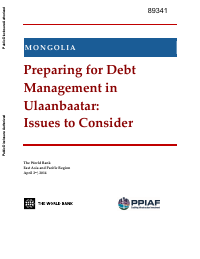

time: 805 ms


In [11]:
row = pr.iloc[0]
dc = DocumentCover(row['id'], row['url_pdf'], COVER_DIR)
dc.standardize_size()
dc.cover

In [ ]:
def parallel_process(row):
    ret = dict(status='ok', doc_id=row['id'])
    try:
        dc = DocumentCover(row['id'], row['url_pdf'], COVER_DIR)
        r = dc.save()
        dc.cleanup()
    except Exception as e:
        ret['status'] = e.__str__()
        
    return ret

In [ ]:
NUM_JOBS = 24

pres = Parallel(n_jobs=NUM_JOBS)(delayed(parallel_process)(row) for _, row in pr.iterrows())